# Pore filtering

We are going to follow Javis advices in pore filtering.

We have to select a few pore level morphological features, and monitor the changes in their distributions when we clean pores based on their area(number of pixels)

## imports

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tifffile as tiff
from tqdm import tqdm
from skimage.measure import regionprops

In [72]:
onylpores_path = Path(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\02_XCT_data\Juan Ignacio\probetas\4\frontal_90right_onlypores.tif')

onylpores_volume = tiff.imread(onylpores_path)

onylpores_volume.shape

(225, 3279, 1542)

## Labeling

In [78]:
#label the pores
from skimage import measure,morphology

labeled_pores = measure.label(onylpores_volume, connectivity=1)

labeled_pores = morphology.remove_small_objects(labeled_pores, min_size=2)

## Morphological features

Javi recommended to use cenital orientation and flatness

In [80]:

import numpy as np
from tqdm import tqdm

def properties(labeled_pores):
    # Calculate the flatness, zenithal orientation, and sphericity for each labeled region
    flatness_list = []
    zenithal_orientation_list = []

    for region in tqdm(regionprops(labeled_pores)):

        try:
            # Get the coordinates of the region
            coords = region.coords

            # Calculate the covariance matrix of the coordinates
            cov_matrix = np.cov(coords, rowvar=False)

            # Calculate the eigenvalues and eigenvectors of the covariance matrix
            eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

            # Calculate the flatness as the ratio of the smallest eigenvalue to the largest eigenvalue
            flatness = eigenvalues.min() / eigenvalues.max()
            flatness_list.append(flatness)

            # The eigenvector corresponding to the largest eigenvalue
            principal_axis = eigenvectors[:, np.argmax(eigenvalues)]

            # Calculate the zenithal orientation as the angle with the vertical axis (z-axis)
            vertical_axis = np.array([1, 0, 0])
            cos_theta = np.dot(principal_axis, vertical_axis) / (np.linalg.norm(principal_axis) * np.linalg.norm(vertical_axis))
            zenithal_orientation = np.arccos(cos_theta)
            zenithal_orientation_list.append(np.degrees(zenithal_orientation))
            
        except Exception as e:
            print(region.area)
            print(region.bbox)
            

    return flatness_list, zenithal_orientation_list

100%|██████████| 2956/2956 [00:00<00:00, 3510.41it/s]


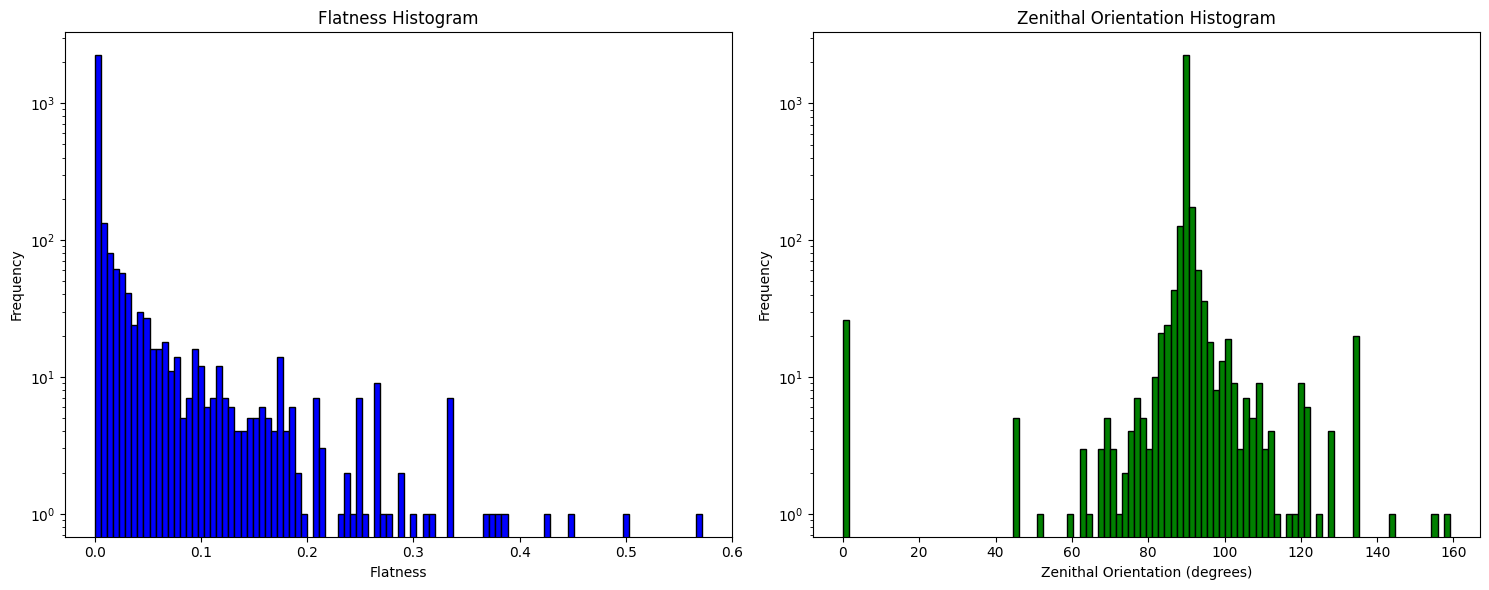

In [81]:
pore_properties = properties(labeled_pores)

bins = 100

# Assuming flatness_list, zenithal_orientation_list, and sphericity_list are the results from the properties function
flatness_list, zenithal_orientation_list = pore_properties

# Create a figure with three subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot histogram for flatness
axes[0].hist(flatness_list, bins=bins, color='blue', edgecolor='black')
axes[0].set_title('Flatness Histogram')
axes[0].set_xlabel('Flatness')
axes[0].set_ylabel('Frequency')
axes[0].set_yscale('log')

# Plot histogram for zenithal orientation
axes[1].hist(zenithal_orientation_list, bins=bins, color='green', edgecolor='black')
axes[1].set_title('Zenithal Orientation Histogram')
axes[1].set_xlabel('Zenithal Orientation (degrees)')
axes[1].set_ylabel('Frequency')
axes[1].set_yscale('log')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## filtering

100%|██████████| 1788/1788 [00:00<00:00, 2453.78it/s]


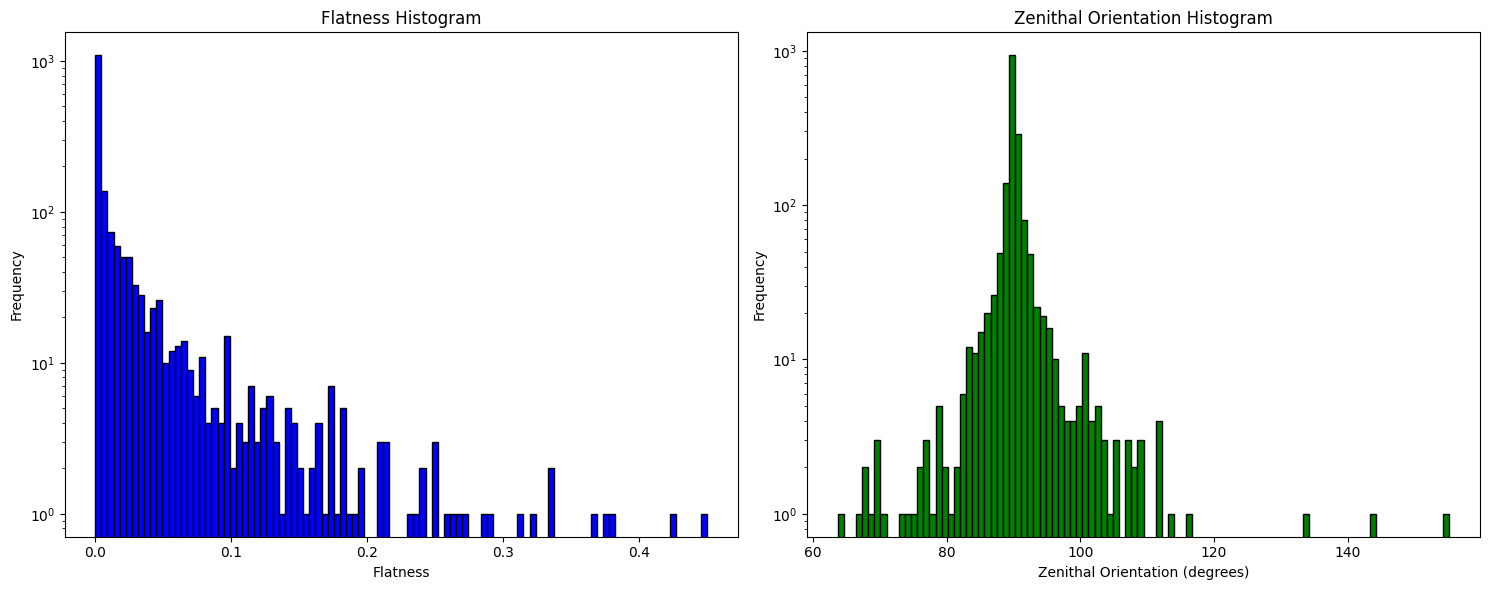

In [82]:
filtered_pores = morphology.remove_small_objects(labeled_pores, min_size=8)

pore_properties_filtered = properties(filtered_pores)

# Assuming flatness_list, zenithal_orientation_list, and sphericity_list are the results from the properties function
flatness_list, zenithal_orientation_list = pore_properties_filtered

# Create a figure with three subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot histogram for flatness
axes[0].hist(flatness_list, bins=bins, color='blue', edgecolor='black')
axes[0].set_title('Flatness Histogram')
axes[0].set_xlabel('Flatness')
axes[0].set_ylabel('Frequency')
axes[0].set_yscale('log')

# Plot histogram for zenithal orientation
axes[1].hist(zenithal_orientation_list, bins=bins, color='green', edgecolor='black')
axes[1].set_title('Zenithal Orientation Histogram')
axes[1].set_xlabel('Zenithal Orientation (degrees)')
axes[1].set_ylabel('Frequency')
axes[1].set_yscale('log')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

100%|██████████| 1398/1398 [00:00<00:00, 2125.07it/s]


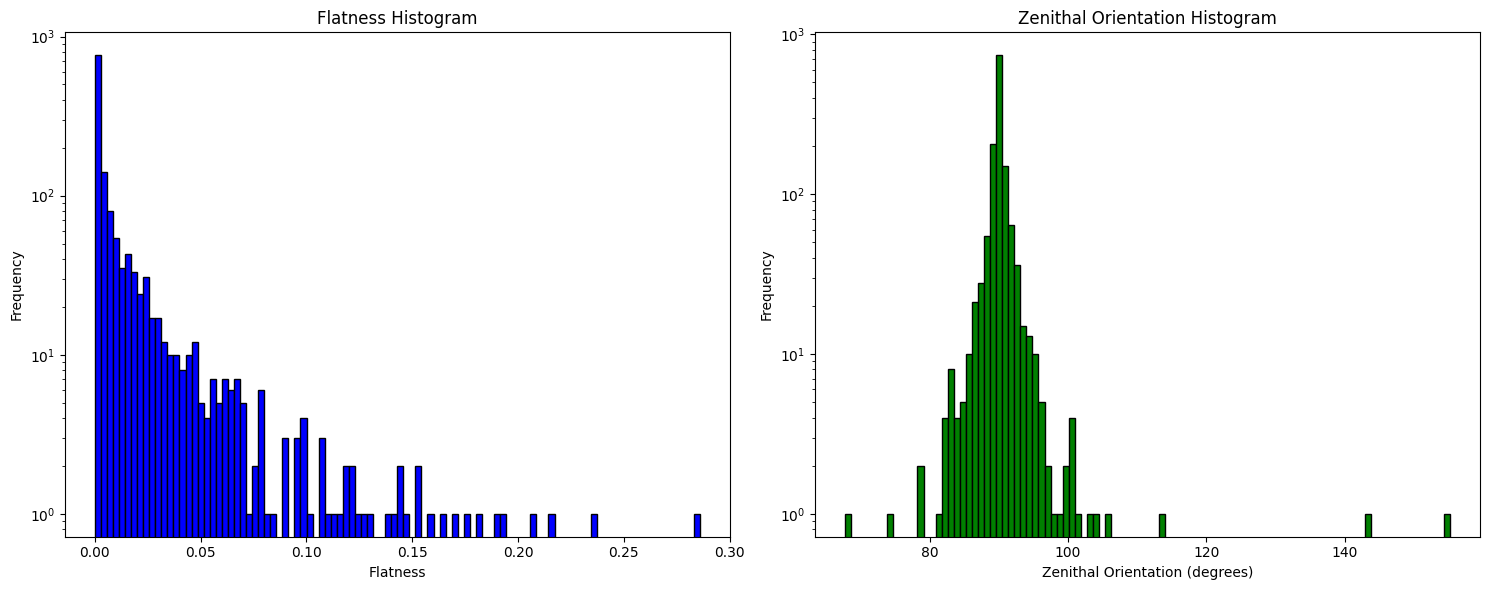

In [83]:
filtered_pores_2 = morphology.remove_small_objects(labeled_pores, min_size=16)

pore_properties_filtered_2 = properties(filtered_pores_2)

# Assuming flatness_list, zenithal_orientation_list, and sphericity_list are the results from the properties function
flatness_list, zenithal_orientation_list = pore_properties_filtered_2

# Create a figure with three subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot histogram for flatness
axes[0].hist(flatness_list, bins=bins, color='blue', edgecolor='black')
axes[0].set_title('Flatness Histogram')
axes[0].set_xlabel('Flatness')
axes[0].set_ylabel('Frequency')
axes[0].set_yscale('log')

# Plot histogram for zenithal orientation
axes[1].hist(zenithal_orientation_list, bins=bins, color='green', edgecolor='black')
axes[1].set_title('Zenithal Orientation Histogram')
axes[1].set_xlabel('Zenithal Orientation (degrees)')
axes[1].set_ylabel('Frequency')
axes[1].set_yscale('log')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Flat filtering

We are going to filter the pores that are not 3D, i mean, a pore must have at least 2 pixels in each axes.

Javi told me something like this (but more technical).

In [84]:
import numpy as np
from scipy.ndimage import label

props = regionprops(filtered_pores)

# Create a mask to keep only the objects that are 2 pixels wide in each axis
mask = np.zeros_like(filtered_pores, dtype=bool)

for prop in tqdm(props):
    # Get the bounding box of the object
    min_row, min_col, min_depth, max_row, max_col, max_depth = prop.bbox
    # Check if the object is 2 pixels wide in each axis
    if (max_row - min_row >= 2) and (max_col - min_col >= 2) and (max_depth - min_depth >= 2):
        mask[prop.slice] = labeled_pores[prop.slice] == prop.label

# Apply the mask to the labeled volume
filtered_pores_3 = filtered_pores * mask

100%|██████████| 1788/1788 [00:00<00:00, 3057.99it/s]


100%|██████████| 1418/1418 [00:00<00:00, 2469.52it/s]


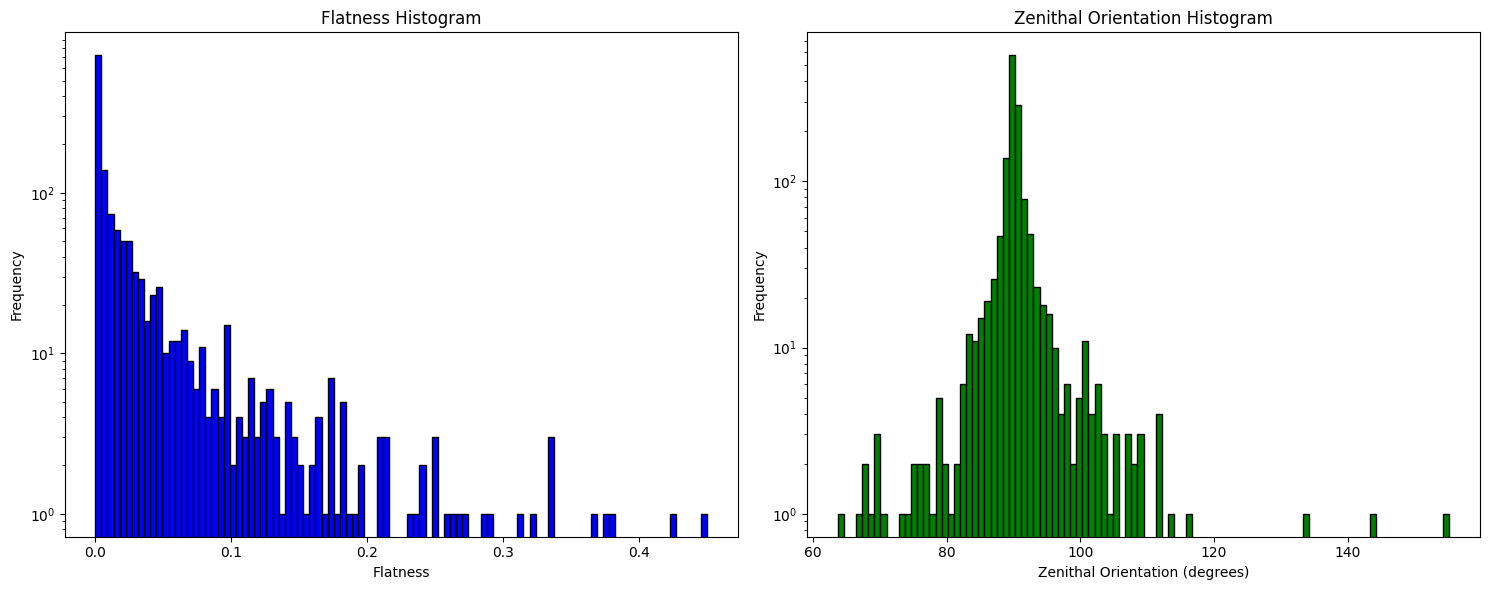

In [86]:
pore_properties_filtered_3 = properties(filtered_pores_3)

# Assuming flatness_list, zenithal_orientation_list, and sphericity_list are the results from the properties function
flatness_list, zenithal_orientation_list = pore_properties_filtered_3

# Create a figure with three subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot histogram for flatness
axes[0].hist(flatness_list, bins=bins, color='blue', edgecolor='black')
axes[0].set_title('Flatness Histogram')
axes[0].set_xlabel('Flatness')
axes[0].set_ylabel('Frequency')
axes[0].set_yscale('log')

# Plot histogram for zenithal orientation
axes[1].hist(zenithal_orientation_list, bins=bins, color='green', edgecolor='black')
axes[1].set_title('Zenithal Orientation Histogram')
axes[1].set_xlabel('Zenithal Orientation (degrees)')
axes[1].set_ylabel('Frequency')
axes[1].set_yscale('log')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## plot the projections

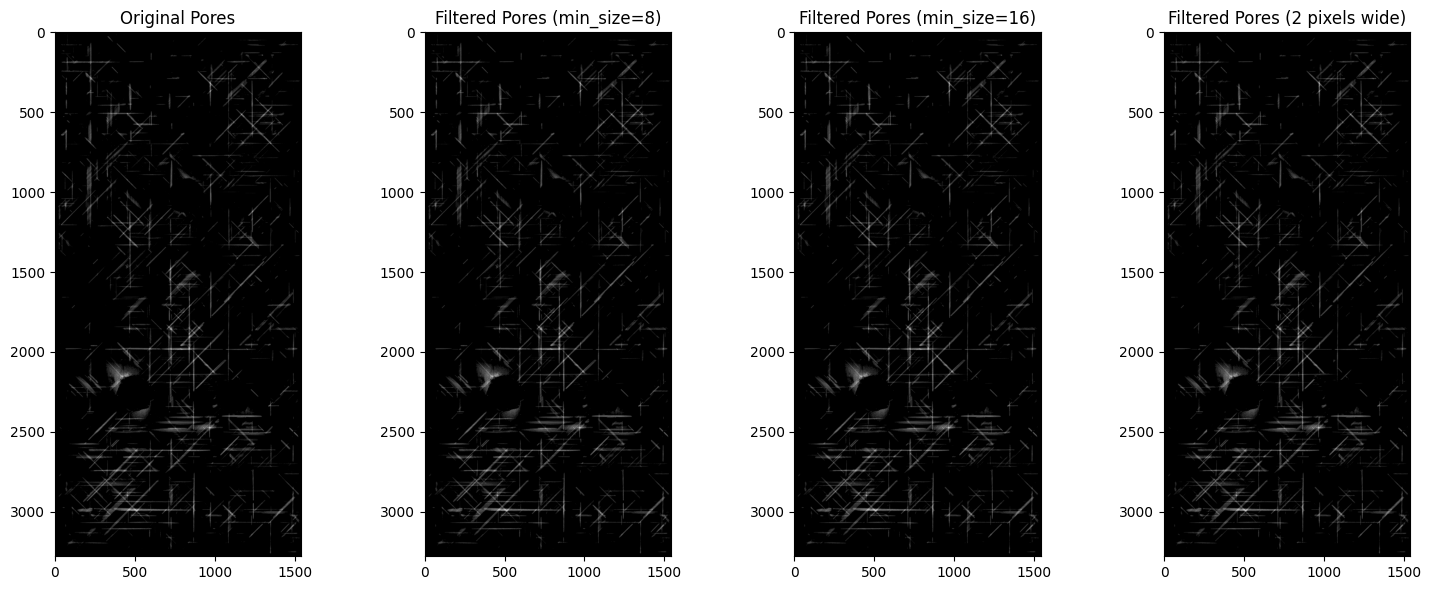

In [87]:
max_proj=np.sum(onylpores_volume, axis=0)

max_proj_filtered=np.sum(filtered_pores > 0, axis=0) 

max_proj_filtered_2=np.sum(filtered_pores_2 > 0, axis=0) 

max_proj_filtered_3=np.sum(filtered_pores_3 > 0, axis=0)

fig, axes = plt.subplots(1, 4, figsize=(15, 6))

axes[0].imshow(max_proj, cmap='gray')
axes[0].set_title('Original Pores')

axes[1].imshow(max_proj_filtered, cmap='gray')
axes[1].set_title('Filtered Pores (min_size=8)')

axes[2].imshow(max_proj_filtered_2, cmap='gray')
axes[2].set_title('Filtered Pores (min_size=16)')

axes[3].imshow(max_proj_filtered_3, cmap='gray')
axes[3].set_title('Filtered Pores (2 pixels wide)')


plt.tight_layout()
plt.show()

In [70]:
print('Original volume pixel count:',np.sum(onylpores_volume > 0))
print('Original >2 filtered pixel count:',np.sum(labeled_pores > 0))
print('Original 8 filtered pixel count:',np.sum(filtered_pores > 0))
print('Original 16 filtered pixel count:',np.sum(filtered_pores_2 > 0))

Original volume pixel count: 1854497
Original >2 filtered pixel count: 1812396
Original 8 filtered pixel count: 1811995
Original 16 filtered pixel count: 1810270
